In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline 
plt.style.use('ggplot')

In [3]:
# !wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2020-09-20 21:09:47--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com... 151.101.52.133
Connecting to raw.githubusercontent.com|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: 'shampoo.csv'

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2020-09-20 21:09:48 (10.8 MB/s) - 'shampoo.csv' saved [519/519]



In [5]:
# load the data
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0],
                    index_col=0, squeeze=0, date_parser=parser)

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


            Sales
Month            
1901-01-01  266.0
1901-02-01  145.9
1901-03-01  183.1
1901-04-01  119.3
1901-05-01  180.3


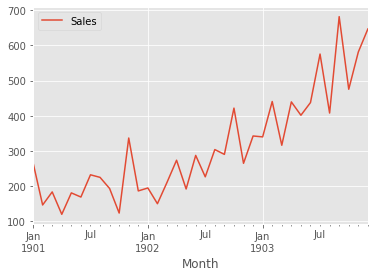

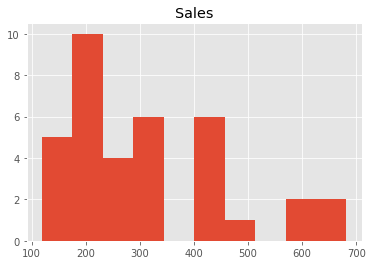

In [7]:
print(series.head())
series.plot()
series.hist()
plt.show()

In [20]:
# prepare the data for modeling:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    
    train, test = supervised_values[0: -n_test], supervised_values[-n_test:]
    return train, test

In [28]:
n_lag = 1
n_seq = 3
n_test = 10

train, test = prepare_data(series, n_test, n_lag, n_seq)

In [31]:
print(test)
print(train.shape, test.shape)


[[342.3 339.7 440.4 315.9]
 [339.7 440.4 315.9 439.3]
 [440.4 315.9 439.3 401.3]
 [315.9 439.3 401.3 437.4]
 [439.3 401.3 437.4 575.5]
 [401.3 437.4 575.5 407.6]
 [437.4 575.5 407.6 682. ]
 [575.5 407.6 682.  475.3]
 [407.6 682.  475.3 581.3]
 [682.  475.3 581.3 646.9]]
(23, 4) (10, 4)


In [32]:
def persistence(last_ob, n_seq):
    return [last_ob for i in range(n_seq)]

In [35]:
def make_forecasts(train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = persistence(X[-1], n_seq)
        forecasts.append(forecast)
    return forecasts

In [36]:
forecasts = make_forecasts(train, test, 1, 3)

In [47]:
def evaluate_forecasts(Test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = test[:, (n_lag+i)]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print(f'RMSE: {(i+1), rmse}')

In [81]:
def plot_forecasts(series, forecasts, n_test):
    plt.plot(series.values)
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='blue')
    
    plt.show()

In [82]:
forecasts

[[342.3, 342.3, 342.3],
 [339.7, 339.7, 339.7],
 [440.4, 440.4, 440.4],
 [315.9, 315.9, 315.9],
 [439.3, 439.3, 439.3],
 [401.3, 401.3, 401.3],
 [437.4, 437.4, 437.4],
 [575.5, 575.5, 575.5],
 [407.6, 407.6, 407.6],
 [682.0, 682.0, 682.0]]

In [83]:
evaluate_forecasts(test, forecasts, n_lag, n_seq)

RMSE: (1, 144.53530364585671)
RMSE: (2, 86.47990518033654)
RMSE: (3, 121.14916838344374)


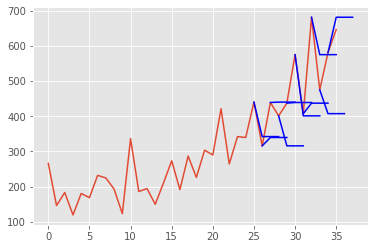

In [84]:
plot_forecasts(series, forecasts, n_test)

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

Using TensorFlow backend.


In [ ]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(Value)
    return pd.Series(diff)

